In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import qutip as qt
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm)
import lattpy as lp
from scipy.optimize import curve_fit
from scipy.linalg import expm

<Figure size 640x480 with 0 Axes>

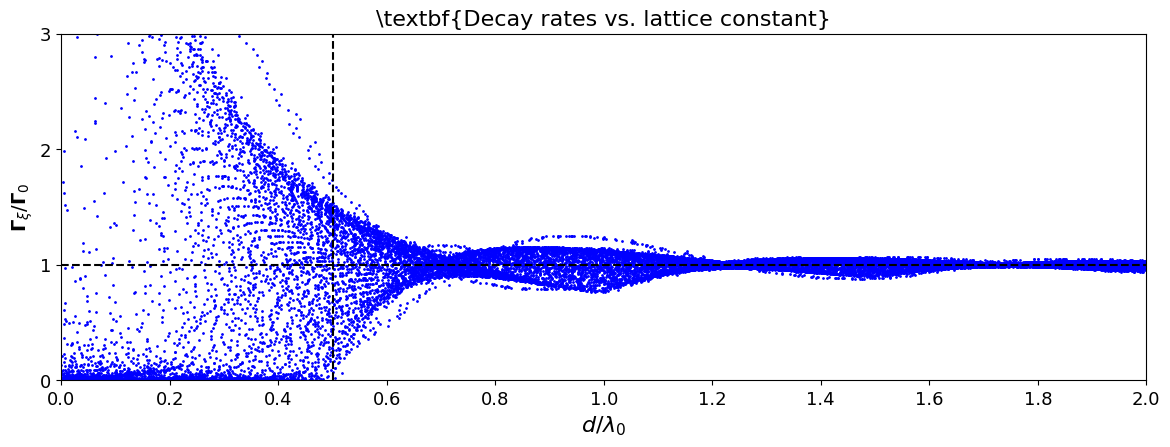

In [4]:
N = 50
N2=3
d_value=1
gamma0 = 1
lambda0=2*np.pi
distances = np.arange(0.00001*np.pi, 4*np.pi, 0.01*np.pi)
k0=1

atoms1 = np.zeros((N, 3), dtype=np.complex128)
atoms2 = np.zeros((N2, 3), dtype=np.complex128)


decay_rates_dictionary = {}

middle_index = N // 2  

for index,distance in enumerate(distances):
    for i in range(N):
        atoms1[i, 2] = i * distance*k0
    for i in range(N2):
        atoms2[i, 2] = (middle_index - N2 // 2 + i) * distance*k0  
        atoms2[i, 1] = distance*k0

    r1 = [atoms1[i] for i in range(N)]
    r2 = [atoms2[i] for i in range(N2)]
    r_T1 = [i.reshape(-1, 1) for i in r1]
    r_T2 = [i.reshape(-1, 1) for i in r2]

    d=np.array([0,d_value,0])
    d_abs=np.linalg.norm(d)
    d = d.reshape(-1, 1)
    d_T=d.reshape(1, -1)

    def G0(rij,k0): 
        r0=np.linalg.norm(rij)
        rij_T = rij.reshape(-1, 1)
        return ((3*np.pi*k0*np.exp(1j*k0*r0))/(4*np.pi*(k0*r0)**3))*((k0**2*r0**2+1j*k0*r0-1)*np.identity(3)+((-k0**2*r0**2-3j*k0*r0+3)*(np.dot(rij,rij_T)/r0**2)))

    def H_eff(r1, r2, d, N, N2):
        Matrix = np.zeros((N + N2, N + N2), dtype=np.complex128)  
        k0=1
        for i in range(N + N2):
            for j in range(N + N2):
                if i == j:
                    Matrix[i, j] +=1 -1j*gamma0/2
                else:
                    if i < N and j < N: 
                        rij = r1[i] - r1[j]
                    elif i >= N and j >= N:  
                        rij = r2[i-N] - r2[j-N]
                    elif i < N and j >= N:  
                        rij = np.abs(r1[i] - r2[j-N])  
                    else:  
                        rij = np.abs(r2[i-N] - r1[j])  
                    Matrix[i, j] += -np.dot(d_T, np.dot(G0(rij,k0), d))
        return  Matrix

    H_eff_matrix = H_eff(r1, r2, d, N, N2)
    eigenvalues = np.imag(np.linalg.eigvals(H_eff_matrix))
    H_eff_imag_eigenvalues_sorted = np.sort(eigenvalues)


    decay_rates_dictionary[distance]=np.abs((2*H_eff_imag_eigenvalues_sorted/-1*gamma0))

plt.figure()
plt.figure(figsize=(14, 4.5)) 
for distance, decay_rates in decay_rates_dictionary.items():
    lattice_constant = distance / lambda0
    jitter = np.random.normal(0, 0.01, size=len(decay_rates))
    plt.scatter(lattice_constant + jitter, decay_rates, s=1, color='blue')


plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

plt.title(r'\textbf{Decay rates vs. lattice constant}', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel(r'$d / \lambda_{0}$', fontsize=16)
plt.ylabel(r'$\mathbf{\Gamma}_{\xi} / \mathbf{\Gamma}_{0}$', fontsize=14)


plt.axhline(y=1, color='black', linestyle='--')
plt.axvline(x=0.5, color='black', linestyle='--')
plt.ylim([0, 3])
plt.xlim([0, 2])
plt.xticks(np.arange(min(distances/lambda0), max(distances/lambda0)+0.2, 0.2))
plt.yticks(np.arange(0, 3.001, 1))

plt.show()

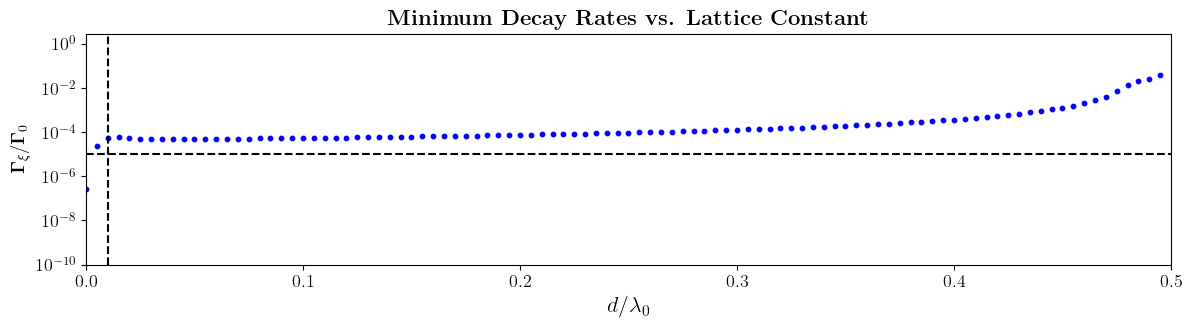

In [5]:

N = 50
N2 = 3
d_value = 1
gamma0 = 1
lambda0 = 2 * np.pi
distances = np.arange(0.00001 * np.pi, 4 * np.pi, 0.01 * np.pi)
k0 = 1


atoms1 = np.zeros((N, 3), dtype=np.complex128)
atoms2 = np.zeros((N2, 3), dtype=np.complex128)
decay_rates_dictionary = {}
middle_index = N // 2  

def G0(rij, k0):
    r0 = np.linalg.norm(rij)
    rij_T = rij.reshape(-1, 1)
    return ((3 * np.pi * k0 * np.exp(1j * k0 * r0)) / (4 * np.pi * (k0 * r0)**3)) * \
           ((k0**2 * r0**2 + 1j * k0 * r0 - 1) * np.identity(3) +
            ((-k0**2 * r0**2 - 3j * k0 * r0 + 3) * (np.dot(rij, rij_T) / r0**2)))

"""added the interaction with the second chain"""
def H_eff(r1, r2, d, N, N2):
    Matrix = np.zeros((N + N2, N + N2), dtype=np.complex128)  
    k0 = 1
    for i in range(N + N2):
        for j in range(N + N2):
            if i == j:
                Matrix[i, j] += -1j * gamma0 / 2
            else:
                if i < N and j < N:
                    rij = r1[i] - r1[j]
                elif i >= N and j >= N:
                    rij = r2[i - N] - r2[j - N]
                elif i < N and j >= N:
                    rij = np.abs(r1[i] - r2[j - N])
                else:
                    rij = np.abs(r2[i - N] - r1[j])
                Matrix[i, j] += -np.dot(d_T, np.dot(G0(rij, k0), d))
    return Matrix


lattice_constants = []
min_decay_rates_combined = []

"""changed atom position"""
for index, distance in enumerate(distances):
    for i in range(N):
        atoms1[i, 2] = i * distance * k0  
    for i in range(N2):
        atoms2[i, 2] = (middle_index - N2 // 2 + i) * distance * k0  
        atoms2[i, 1] = distance * k0  

    r1 = [atoms1[i] for i in range(N)]
    r2 = [atoms2[i] for i in range(N2)]
    r_T1 = [i.reshape(-1, 1) for i in r1]
    r_T2 = [i.reshape(-1, 1) for i in r2]

    d = np.array([0, d_value, 0])
    d_abs = np.linalg.norm(d)
    d = d.reshape(-1, 1)
    d_T = d.reshape(1, -1)

    H_eff_matrix = H_eff(r1, r2, d, N, N2)
    eigenvalues = np.imag(np.linalg.eigvals(H_eff_matrix))
    H_eff_imag_eigenvalues_sorted = np.sort(eigenvalues)
    decay_rates = (2 * H_eff_imag_eigenvalues_sorted / (- gamma0))
    
    lattice_constant = distance / lambda0
    if lattice_constant <= 0.5:
        lattice_constants.append(lattice_constant)
        min_decay_rates_combined.append(np.min(decay_rates))

lattice_constants = np.array(lattice_constants)
min_decay_rates_combined = np.array(min_decay_rates_combined)

fig, ax = plt.subplots(figsize=(14, 3))

ax.scatter(lattice_constants, min_decay_rates_combined, s=10, color='blue', label='Combined Chains')

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

ax.set_title(r'\textbf{Minimum Decay Rates vs. Lattice Constant}', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel(r'$d / \lambda_{0}$', fontsize=16)
ax.set_ylabel(r'$\mathbf{\Gamma}_{\xi} / \mathbf{\Gamma}_{0}$', fontsize=14)

ax.axhline(y=10**-5, color='black', linestyle='--')
ax.axvline(x=0.01, color='black', linestyle='--')
ax.set_ylim([1e-10, 3])
ax.set_xlim([0, 0.5])
ax.set_yscale('log')
plt.show()

sorted_combined_rates_with_constants = sorted(zip(lattice_constants, min_decay_rates_combined), key=lambda x: x[0])